# Diffusion Processes on Complex Networks

Katarzyna Ciesiółka

Link to my GitLap repository with solution: https://gitlab.com/249755/diffusion-processes-on-complex-networks.git

## Assignment 6

In [1]:
from l2 import *
from l3 import *
from l4 import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### a)
Implement the model with $NN$ influence group.

I added attribute opinion to my class Vertex. Here is the very begining of this class:
```python
class Vertex:
    def __init__(self, num):
        self.id = num
        self.connected_to = {}
        self.dist = sys.maxsize
        self.opinion = 1
```

I also added methods change_opinion, get_opinions_list, get_opinion and set_opinion to my Graph class, which I present here:
```python
def change_opinion(self, vertex):
        if self.get_vertex(vertex).opinion == 1:
            self.get_vertex(vertex).opinion = 0
        elif self.get_vertex(vertex).opinion == 0:
            self.get_vertex(vertex).opinion = 1

def get_opinions_list(self):
        opinions = []
        for vert in self.get_vertices():
            opinions.append(self.get_vertex(vert).opinion)
        return opinions

def get_opinion(self, vertex):
        return self.get_vertex(vertex).opinion

def set_opinion(self, vertex, new_opinion):
        self.get_vertex(vertex).opinion = new_opinion
```

Function which is responsible for one spinson action on given graph and with given parameters:

In [3]:
def spinson_action(graph, spinson, p, f=0.5, q=4):
    if np.random.rand() < p:
        if np.random.rand() < f:
            graph.change_opinion(spinson)
    else:
        if len(graph.get_neighbors(spinson)) >= q:
            nei = np.random.choice(graph.get_neighbors(spinson), q, 
                                                        replace=False)
        else:
            nei = graph.get_neighbors(spinson)
        nei_opinions = [graph.get_opinion(n) for n in nei]
        if sum(nei_opinions) == 0 or sum(nei_opinions) == len(nei):
            graph.set_opinion(spinson, int(sum(nei_opinions)/len(nei)))

I also added reset_opinions method to Graph class:
```python
def reset_opinions(self):
        for vert in self.get_vertices():
            self.set_opinion(vert, 1)
```

### b)

Simulate the model with $N = 100$ agents, $q = 3$ and $4$, and the independence factor $p$ ranging from $0.0$ to $0.5$ with step $0.02$. Use the following networks as the underlying topology of social interactions: complete graph, $BA(100,4)$, $WS(100,4,0.01)$, $WS(100,4,0.2)$. Finish the simulations after $1000$ Monte Carlo steps.

Function which generates complete graph:

In [4]:
def complete_graph(N):
    edges_list = []
    for i in range(N):
        for j in range(i+1, N):
            edges_list.append([i, j])
    g = Graph()
    g.add_edges_from_list(edges_list)
    return g

I changed value of Monte Carlo steps from $1000$ to $100$, because of execution time.

In [5]:
N = 100
MC = 100
IR = 100

Generating necesary graphs:

In [6]:
graph_comp = complete_graph(N)
graph_BA = Barabasi_Albert(N, 4, 4)
graph_WS1 = Watts_Strogatz(N, 4, 0.01)
graph_WS2 = Watts_Strogatz(N, 4, 0.2)

### c)

For each parameter set calculate the magnetization in the system as a function of time, averaged over $100$ independent runs.

Function which returns magnetization in time:

In [7]:
def magnetization(graph, MC, p, q, f=0.5):
    graph.reset_opinions()
    magnetization = np.zeros(MC)
    magnetization[0] = np.mean(graph.get_opinions_list())
    for i in range(1, MC):
        time_nodes = np.random.choice(graph.get_vertices(), 
                                            graph.num_vertices)
        for spinson in time_nodes:
            spinson_action(graph, spinson, p, f, q)
        magnetization[i] = np.mean(graph.get_opinions_list())
    return list(magnetization)

Function which returns average magnetization in time:

In [8]:
def magnetization_runs(graph, MC, IR, p, q, f=0.5):
    mag = np.zeros((MC, IR))
    for r in range(IR):
        mag[r,:] = magnetization(graph, MC, p, q, f)
    return np.mean(mag, axis=0)

### d)

Plot the time evolution of the magnetization for the $WS(100,4,0.01)$ network (both averaged and from single run).

In [24]:
def plot_magnetization_evolution(graph, MC, IR, p, q, f=0.5):
    plt.figure(figsize=(7.5,5))
    plt.plot(list(range(MC)), magnetization(graph, MC, p, q, f), 
                                                label='single run')
    plt.plot(list(range(MC)), magnetization_runs(graph, MC, IR, p, q, f), 
                                            label=f'average of {IR} runs')
    plt.title('Time evolution of the magnetization for $WS(100,4,0.01)$')
    plt.ylabel('magnetization')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

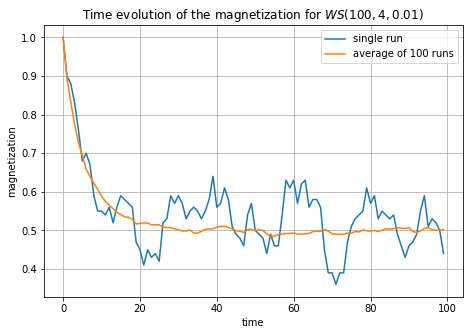

In [25]:
plot_magnetization_evolution(graph_WS1, MC, IR, 0.3, 4)

### e)

Plot the average final magnetization as a function of independence factor $p$ for
* $q = 3$ and different network topologies (one plot),
* $q = 4$ and different network topologies (one plot),
* $WS(100,4,0.01)$ network and different values of $q$ (one plot).

Function which returns final magnetization:

In [10]:
def final_magnetization(graph, MC, p, q, f=0.5):
    graph.reset_opinions()
    for _ in range(1, MC):
        time_nodes = np.random.choice(graph.get_vertices(), 
                                            graph.num_vertices)
        for spinson in time_nodes:
            spinson_action(graph, spinson, p, f, q)
    return np.mean(graph.get_opinions_list())

Function which plots final magnetization for given values of $p$:

In [11]:
def plot_final_magnetization(graph, MC, IR, ps, q):
    mag = []
    for p in ps:
        mag.append(np.mean([final_magnetization(graph, MC, p, q) 
                                            for _ in range(IR)]))
    plt.plot(ps, mag)
    plt.grid()

In [12]:
def plot_magnetizations(graphs, qs, ps, MC, IR):
    plt.figure(figsize=(15,5))
    for i, q in enumerate(qs):
        plt.subplot(1,2,i+1)
        for graph in graphs:
            plot_final_magnetization(graph, MC, IR, ps, q)
        plt.title(f'Final magnetization for $q={q}$')
        plt.legend(['complete', 'BA(100,4)', 'WS(100,4,0.01)', 
                                                'WS(100,4,0.2)'])
        plt.grid()
        plt.ylabel('magnetization')
        plt.xlabel('p')

In [13]:
graphs = [graph_comp, graph_BA, graph_WS1, graph_WS2]
qs = [3, 4]
ps = list(np.arange(0, 0.52, 0.02))

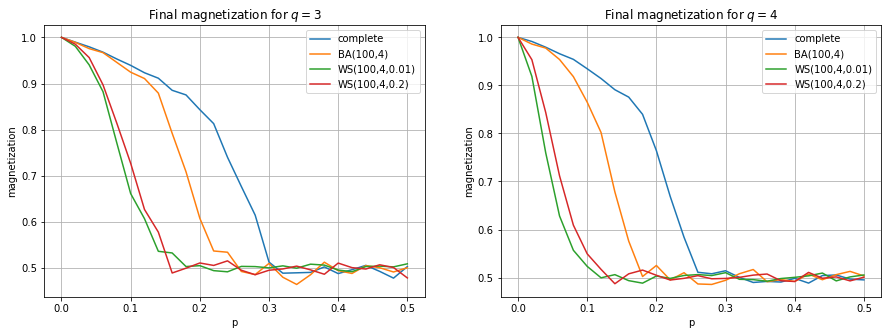

In [52]:
plot_magnetizations(graphs, qs, ps, MC, IR)

In [22]:
def plot_magnetizations_q(graph, qs, ps, MC, IR):
    plt.figure(figsize=(7.5,5))
    for q in qs:
        plot_final_magnetization(graph, MC, IR, ps, q)
    plt.title('Final magnetization for $WS(100,4,0.01)$')
    plt.legend(['$q=3$', '$q=4$'])
    plt.grid()
    plt.ylabel('magnetization')
    plt.xlabel('p')

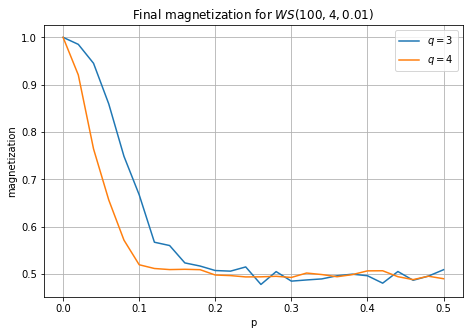

In [23]:
plot_magnetizations_q(graph_WS1, qs, ps, MC, IR)